In [1]:
# Import necessary libraries

import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
# Load the CSV file and set the 'Date' column as the index
df = pd.read_csv('cci301.csv', index_col='Date', parse_dates=True)

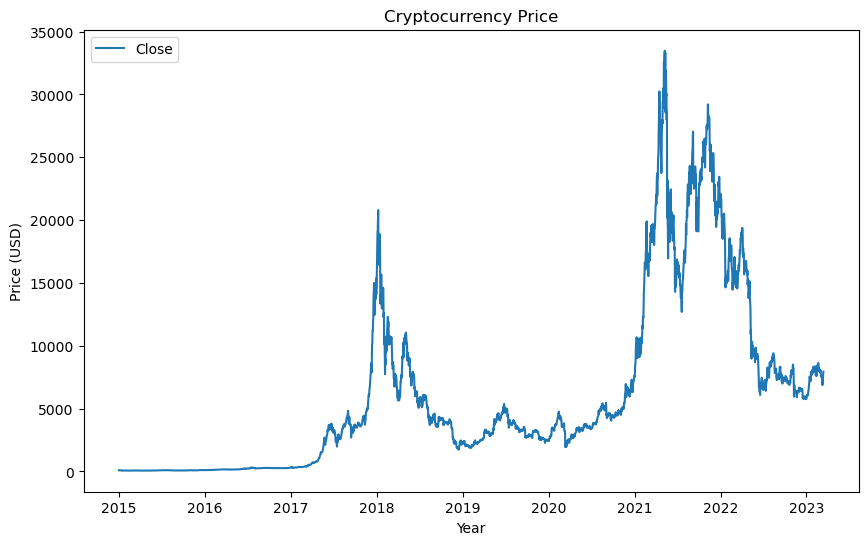

In [3]:
# Plot the time series data
plt.figure(figsize=(10, 6))
plt.plot(df['Close'], label='Close')
plt.title('Cryptocurrency Price')
plt.xlabel('Year')
plt.ylabel('Price (USD)')
plt.legend(loc='upper left')
plt.show()

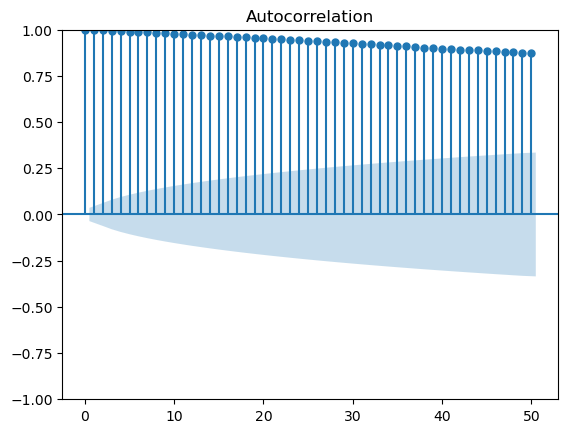

In [4]:
# Check for autocorrelation
plot_acf(df['Close'], lags=50)
plt.show()

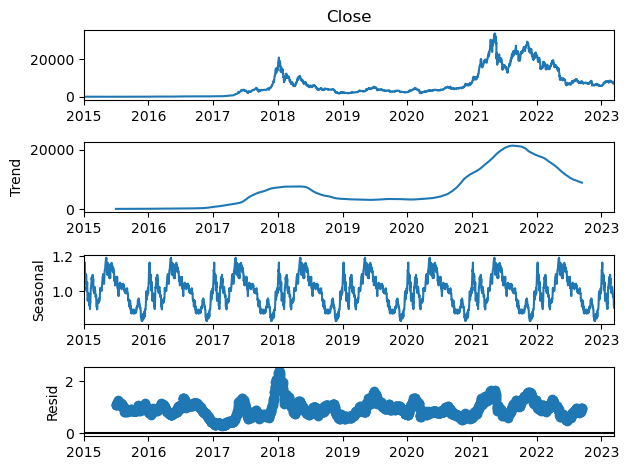

In [5]:
# Check for time series components in the dataset
result = seasonal_decompose(df['Close'], model='multiplicative', period=365)
result.plot()
plt.show()

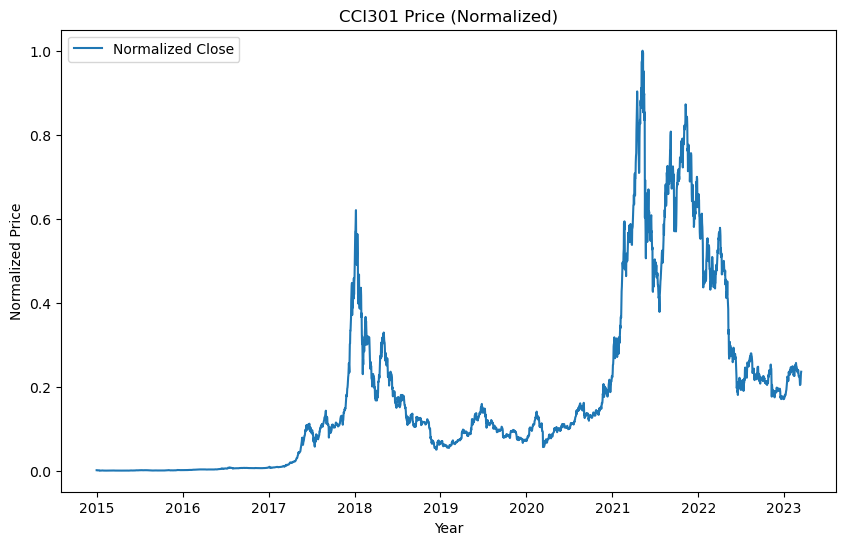

In [6]:
# Find the minimum and maximum values in the dataset
min_val = df['Close'].min()
max_val = df['Close'].max()

# Normalize the data
df_norm = (df['Close'] - min_val) / (max_val - min_val)

# Plot the normalized data
plt.figure(figsize=(10, 6))
plt.plot(df_norm, label='Normalized Close')
plt.title('CCI301 Price (Normalized)')
plt.xlabel('Year')
plt.ylabel('Normalized Price')
plt.legend(loc='upper left')
plt.show()

In [7]:
#Estimating Transition Probabilities 

# Define bull and bear regimes
bull_regime = 1
bear_regime = 0

# Create a list to store the regimes
regime_list = []

# Define the initial regime
if df['Close'][0] < df['Close'][1]:
    regime_list.append(bull_regime)
else:
    regime_list.append(bear_regime)

# Estimate the transition probabilities
num_transitions = 0
bull_to_bear = 0
bull_to_bull = 0
bear_to_bull = 0
bear_to_bear = 0

for i in range(1, len(df)):
    if df['Close'][i] > df['Close'][i-1]:
        regime_list.append(bull_regime)
    else:
        regime_list.append(bear_regime)
    
    if regime_list[i] != regime_list[i-1]:
        num_transitions += 1
        
        if regime_list[i-1] == bull_regime and regime_list[i] == bear_regime:
            bull_to_bear += 1
        elif regime_list[i-1] == bull_regime and regime_list[i] == bull_regime:
            bull_to_bull += 1
        elif regime_list[i-1] == bear_regime and regime_list[i] == bull_regime:
            bear_to_bull += 1
        else:
            bear_to_bear += 1

bull_prob = bull_to_bull / (bull_to_bull + bull_to_bear)
bear_prob = bear_to_bear / (bear_to_bear + bear_to_bull)

print('Bull to Bull Probability:', bull_prob)
print('Bear to Bear Probability:', bear_prob)

# Create the transition matrix
transition_matrix = [[bull_to_bull / (bull_to_bull + bull_to_bear), bull_to_bear / (bull_to_bull + bull_to_bear)],
                     [bear_to_bull / (bear_to_bear + bear_to_bull), bear_to_bear / (bear_to_bear + bear_to_bull)]]

print('Transition Matrix:')
for row in transition_matrix:
    print(row)

Bull to Bull Probability: 0.0
Bear to Bear Probability: 0.0
Transition Matrix:
[0.0, 1.0]
[1.0, 0.0]


In [8]:
#Estimating Initial State Probabilities 

# Calculate the mean and standard deviation of returns for bull and bear regimes
bull_returns = df['Close'][df['Close'].diff() > 0].pct_change().dropna()
bear_returns = df['Close'][df['Close'].diff() < 0].pct_change().dropna()

bull_mean = bull_returns.mean()
bull_std = bull_returns.std()

bear_mean = bear_returns.mean()
bear_std = bear_returns.std()

# Estimate the initial state probabilities
total_returns = df['Close'].pct_change().dropna()

bull_prob = len(total_returns[total_returns > 0]) / len(total_returns)
bear_prob = len(total_returns[total_returns < 0]) / len(total_returns)

if bull_mean > bear_mean:
    initial_state_prob = [bull_prob, 1 - bull_prob]
else:
    initial_state_prob = [1 - bear_prob, bear_prob]

print('Initial State Probabilities:', initial_state_prob)

Initial State Probabilities: [0.5531062124248497, 0.4468937875751503]


In [9]:
#Markov Switching Model Using Maximum Likelihood Estimation (MLE) Method 

import numpy as np

# Define the model parameters
num_states = 2
num_obs = len(df['Close'])

# Define the initial state probabilities
init_prob = np.array(initial_state_prob)

# Define the transition probability matrix
trans_matrix = np.array(transition_matrix)

# Define the observation probabilities
obs_matrix = np.zeros((num_states, num_obs))
for i in range(num_obs):
    obs_matrix[0][i] = np.exp(-(df['Close'][i] - bull_mean)**2 / (2 * bull_std**2))
    obs_matrix[1][i] = np.exp(-(df['Close'][i] - bear_mean)**2 / (2 * bear_std**2))

# Define the forward algorithm
def forward_algo(obs_matrix, trans_matrix, init_prob):
    num_states = trans_matrix.shape[0]
    num_obs = obs_matrix.shape[1]

    alpha = np.zeros((num_states, num_obs))
    alpha[:, 0] = init_prob * obs_matrix[:, 0]

    for t in range(1, num_obs):
        for j in range(num_states):
            alpha[j, t] = obs_matrix[j, t] * np.sum(alpha[:, t-1] * trans_matrix[:, j])
        alpha[:, t] = alpha[:, t] / np.sum(alpha[:, t])

    return alpha

# Define the Viterbi algorithm
def viterbi_algo(obs_matrix, trans_matrix, init_prob):
    num_states = trans_matrix.shape[0]
    num_obs = obs_matrix.shape[1]

    delta = np.zeros((num_states, num_obs))
    delta[:, 0] = init_prob * obs_matrix[:, 0]
    psi = np.zeros((num_states, num_obs))
    psi[:, 0] = 0

    for t in range(1, num_obs):
        for j in range(num_states):
            delta[j, t] = obs_matrix[j, t] * np.max(delta[:, t-1] * trans_matrix[:, j])
            psi[j, t] = np.argmax(delta[:, t-1] * trans_matrix[:, j])

    states = np.zeros(num_obs, dtype=np.int32)
    states[-1] = np.argmax(delta[:, -1])
    for t in range(num_obs-2, -1, -1):
        states[t] = psi[states[t+1], t+1]

    return states

# Estimate the model parameters using the MLE method
def mle_method(obs_matrix, trans_matrix, init_prob):
    alpha = forward_algo(obs_matrix, trans_matrix, init_prob)
    log_likelihood = -np.sum(np.log(np.sum(alpha, axis=0)))
    states = viterbi_algo(obs_matrix, trans_matrix, init_prob)

    return log_likelihood, states

# Make predictions based on the model parameters
log_likelihood, states = mle_method(obs_matrix, trans_matrix, init_prob)
pred_state = states[-1]

if pred_state == 0:
    print('The market is in the bull regime.')
else:
    print('The market is in the bear regime.')

The market is in the bull regime.


C:\Users\nural\AppData\Local\Temp\ipykernel_41444\1296443757.py:30: RuntimeWarning: invalid value encountered in true_divide
  alpha[:, t] = alpha[:, t] / np.sum(alpha[:, t])
C:\Users\nural\AppData\Local\Temp\ipykernel_41444\1296443757.py:59: RuntimeWarning: divide by zero encountered in log
  log_likelihood = -np.sum(np.log(np.sum(alpha, axis=0)))


Number of Bull Days: 2995
Number of Bear Days: 0


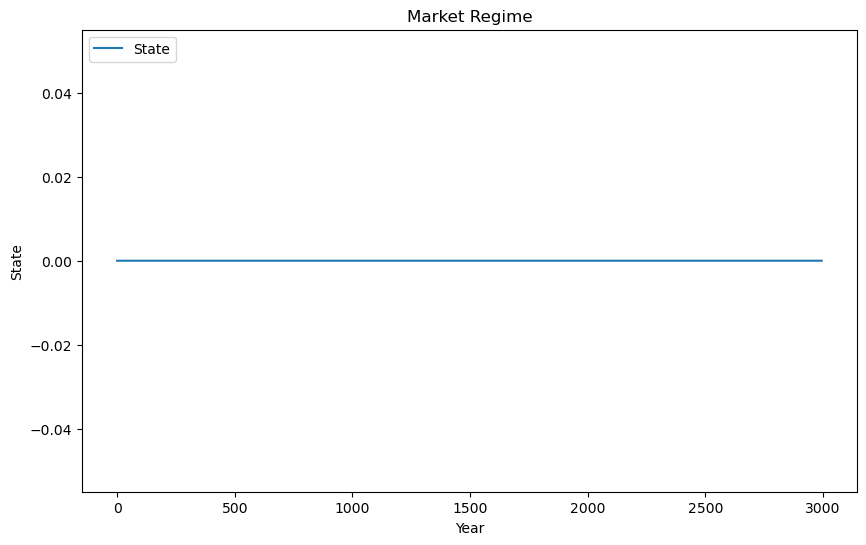

In [10]:
# Find the number of days in each regime

num_bull_days = len(states[states==0])
num_bear_days = len(states[states==1])

print('Number of Bull Days:', num_bull_days)
print('Number of Bear Days:', num_bear_days)

# Plot the state sequence
plt.figure(figsize=(10, 6))
plt.plot(states, label='State')
plt.title('Market Regime')
plt.xlabel('Year')
plt.ylabel('State')
plt.legend(loc='upper left')
plt.show()

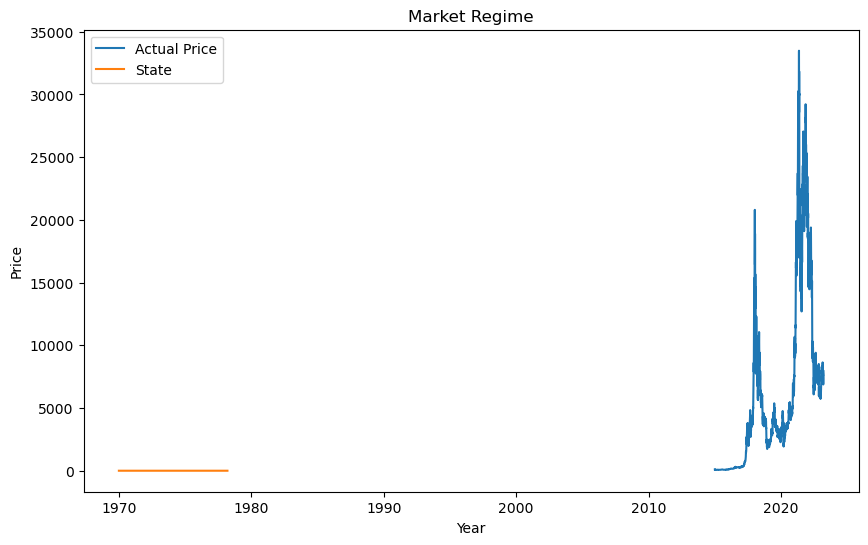

In [11]:
# Plot the actual price series along with the state sequence

plt.figure(figsize=(10, 6))
plt.plot(df['Close'], label='Actual Price')
plt.plot(states * df['Close'].max(), label='State')
plt.title('Market Regime')
plt.xlabel('Year')
plt.ylabel('Price')
plt.legend(loc='upper left')
plt.show()

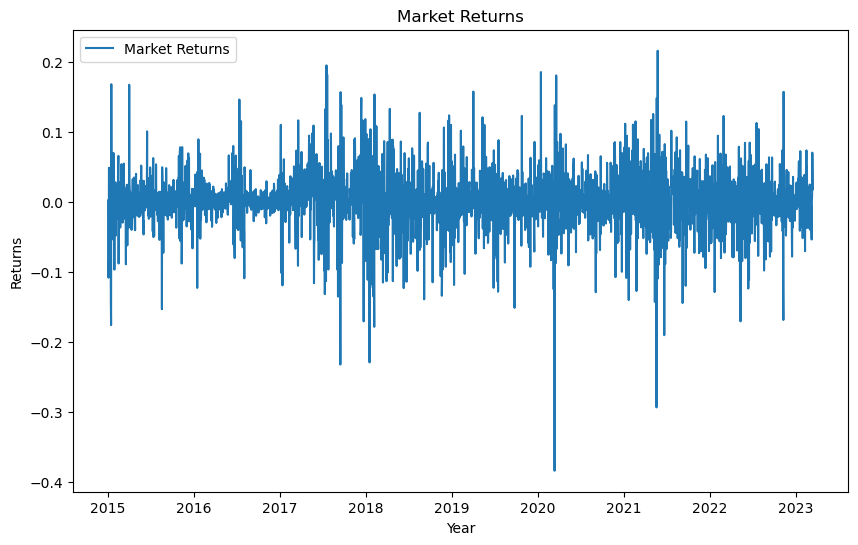

In [12]:
# Calculate the market returns

market_returns = df['Close'].pct_change().dropna()

# Plot the market returns
plt.figure(figsize=(10, 6))
plt.plot(market_returns, label='Market Returns')
plt.title('Market Returns')
plt.xlabel('Year')
plt.ylabel('Returns')
plt.legend(loc='upper left')
plt.show()

C:\Users\nural\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nural\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\nural\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


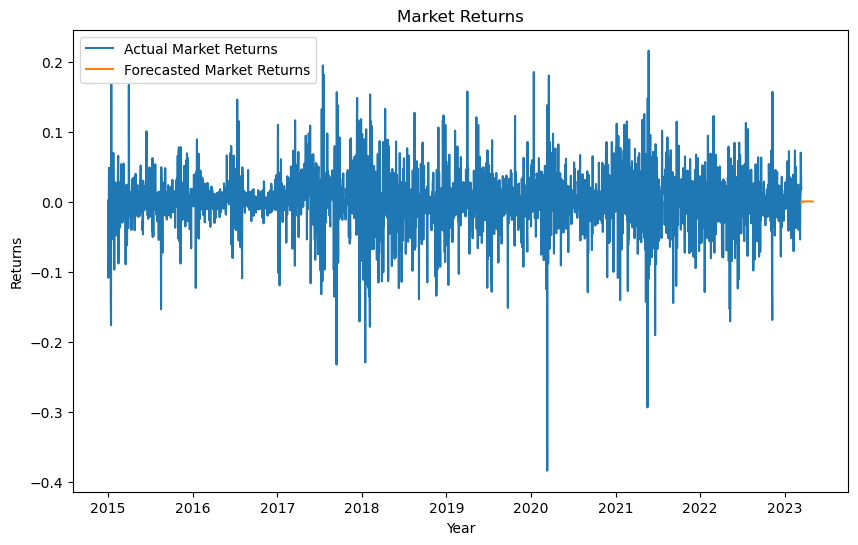

In [13]:
#ARIMA Model to Forecast Future Market Returns 

from statsmodels.tsa.arima.model import ARIMA

# Fit an ARIMA model to the market returns
model = ARIMA(market_returns, order=(1, 1, 1))
results = model.fit()

# Generate the forecasted market returns
forecast = results.forecast(steps=50)

# Plot the actual and forecasted market returns
plt.figure(figsize=(10, 6))
plt.plot(market_returns, label='Actual Market Returns')
plt.plot(forecast, label='Forecasted Market Returns')
plt.title('Market Returns')
plt.xlabel('Year')
plt.ylabel('Returns')
plt.legend(loc='upper left')
plt.show()